## Chapter 2 from Bjornstad (2018): The SIR model

We use the `deSolve` R-package to numerically integrate the equations for the SIR model. We will numerically integrate a variety of different models. While the models differ, the basic recipe is generally the same: (i) define a R-function for the general system of equations, (ii) specify the time points at which we want the integrator to save the state of the system, (iii) provide values for the parameters, (iv) give initial values for all state variables, and finally (v) invoke the R-function that does the integration. We use the `ode`-function in the `deSolve`-package.

In [1]:
library(deSolve)

### Step 1

We define the function (often called the gradient-functions) for the equation systems. The `deSolve`-package requires the function to take the following parameters: time [2], `t`, a vector with the values for the state variables ($S$, $I$, $R$), `y`, and parameter values ($\beta$, $\mu$, $\gamma$ and $N$), `parms`:

In [2]:
sirmod = function(t, y, parms) {
    # Pull state variables from y vector
    S = y[1]
    I = y[2]
    R = y[3]
    # Pull parameter values from parms vector
    beta = parms["beta"]
    mu = parms["mu"]
    gamma = parms["gamma"]
    N = parms["N"]
    # Define equations
    dS = mu * (N - S) - beta * S * I/N
    dI = beta * S * I/N - (mu + gamma) * I
    dR = gamma * I - mu * R
    res = c(dS, dI, dR)
    # Return list of gradients
    list(res)
}

The `ode`-function solves differential equations numerically.

### Steps 2-4

Specify the time points at which we want `ode` to record the states of the system (here we use 26 weeks with 10 time-increments per week as specified in the vector `times`), the parameter values (in this case as specified in the vector `parms`), and starting conditions (specified in `start`). In this case we model the *fraction* of individuals in each class, so we set $N=1$, and consider a disease with an infectious period of 2 weeks ($\gamma = 1/2$), no births or deaths ($\mu = 0$) and a transmission rate of 2 ($\beta = 2$). For our starting conditions we assume that $0.1\%$ of the initial population is infected and the remaining fraction is susceptible.

In [3]:
times = seq(0, 26, by = 1/10)
parms = c(mu = 0, N = 1, beta = 2, gamma = 1/2)
start = c(S = 0.999, I = 0.001, R = 0)

### Step 5

Feed `start` values, `times`, the gradient-function and parameter vector to the `ode`-function as suggested by `args(ode)`[3]. For convenience we convert the output to a data frame (`ode` returns a `list`). The `head`-function shows the first 5 rows of `out`, and `round(,3)` rounds the number to three decimals.

In [4]:
out = ode(y = start, times = times, func = sirmod, 
     parms = parms)
out=as.data.frame(out)
head(round(out, 3))

time,S,I,R
0.0,0.999,0.001,0
0.1,0.999,0.001,0
0.2,0.999,0.001,0
0.3,0.998,0.002,0
0.4,0.998,0.002,0
0.5,0.998,0.002,0


### Plot the result

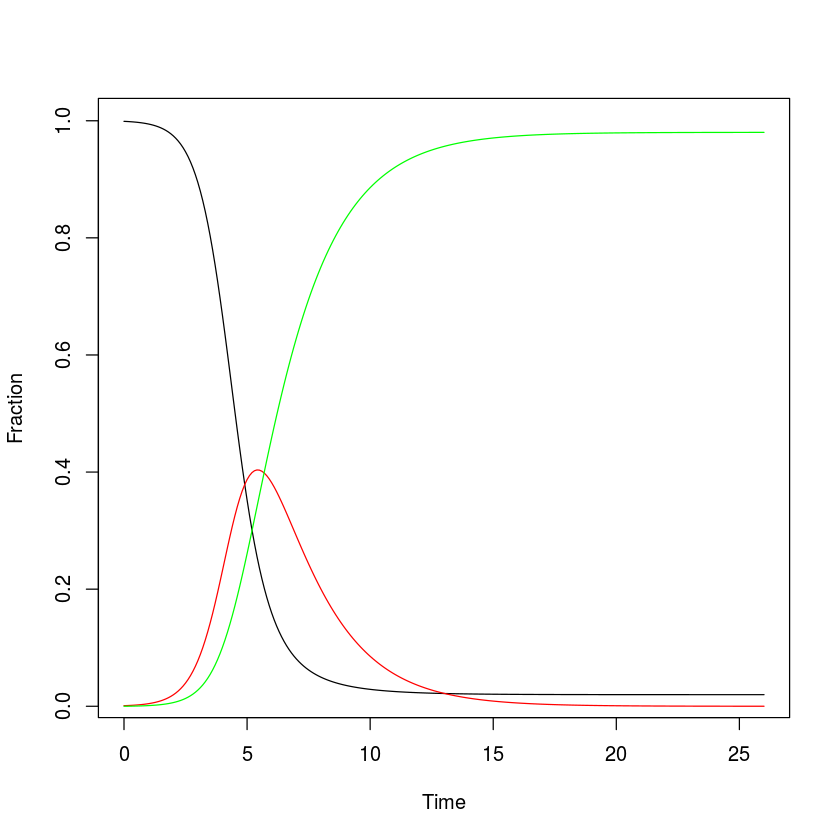

In [5]:
plot(x = out$time, y = out$S, ylab = "Fraction", 
     xlab = "Time", type = "l")
lines(x = out$time, y = out$I, col = "red")
lines(x = out$time, y = out$R, col = "green")

The following figure has some added features such as a right-hand axis for for the *effective* reproductive ratio ($R_E$) – the expected number of new cases per infected individuals in a *not* completely susceptible population – and a legend so that we can confirm that the turnover of the epidemic happens exactly when $R_E = R_0 s =1$, where $s$ is the fraction of remaining susceptibles.

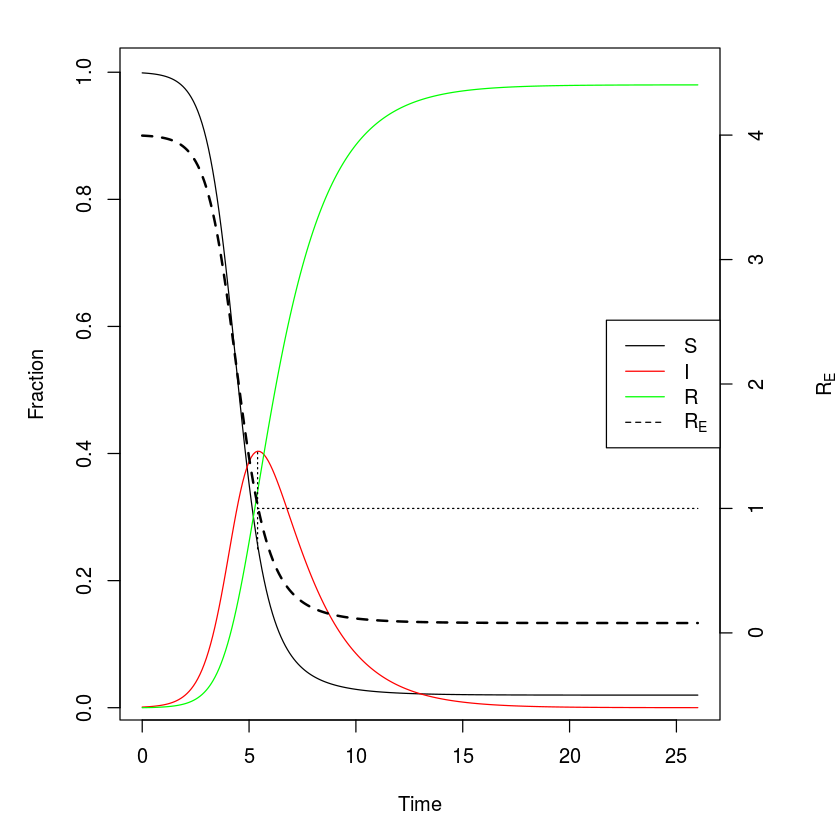

In [6]:
#Calculate R0
R0 = parms["beta"]/(parms["gamma"]+parms["mu"])

#Adjust margins to accommodate a second right axis
par(mar = c(5,5,2,5))
#Plot state variables
plot(x = out$time, y = out$S, ylab = "Fraction",
     xlab = "Time",  type = "l")
lines(x = out$time, y = out$I, col = "red")
lines(x = out$time, y = out$R, col = "green")

#Add vertical line at turnover point
xx = out$time[which.max(out$I)]
lines(c(xx,xx), c(1/R0,max(out$I)), lty = 3)

#prepare to superimpose 2nd plot
par(new = TRUE)
#plot effective reproductive ratio (w/o axes)
plot(x = out$time, y = R0*out$S, type = "l", lty = 2,
     lwd = 2, col = "black", axes = FALSE, xlab = NA, 
     ylab = NA, ylim = c(-.5, 4.5))
lines(c(xx, 26), c(1,1), lty = 3)
#Add right-hand axis for RE
axis(side = 4)
mtext(side = 4, line = 4, expression(R[E]))
#Add legend
legend("right", legend = c("S", "I", "R", 
     expression(R[E])), lty = c(1,1,1, 2),  
     col = c("black", "red", "green", "black"))

### Final epidemic size

The `rootSolve`-package will attempt to find equilibria of systems of differential equations through numerical integration. The function `runsteady` is really just a wrapper function around the `ode`-function that integrates until the system settles on some steady-state (if it exists). It takes the same arguments as `ode`. By varying initial conditions `rootSolve` should find multiple *stable* equilibria if there are more than one stable solution.

In [7]:
library(rootSolve)
equil=runsteady(y=c(S=1-1E-5, I=1E-5, R=0), 
times=c(0,1E5), func=sirmod, parms=parms)
round(equil$y, 3)

S    I    R 
0.02 0.00 0.98

So for these parameters, 2% of susceptibles are expected to escape infection altogether and 98% – the final epidemic size – are expected to be infected during the course of the epidemic.

In the above example we assume an infectious period of 2 weeks (i.e. $\gamma=1/2$), so we may vary $\beta$ so $R_0$ goes from 0.1 to 5. For moderate to large $R_0$ this fraction has been shown to be approximately $1-\exp(-R_0)$ . We can check how well this approximation holds.

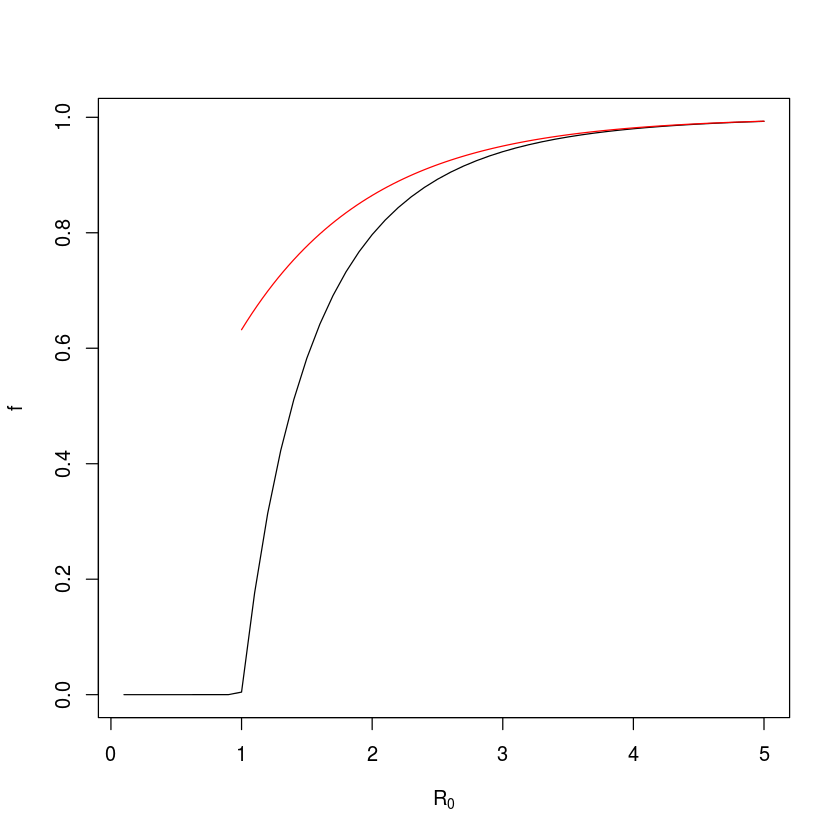

In [8]:
#Candidate values for R0 and beta
R0 = seq(0.1, 5, length=50)
betas= R0 * 1/2
#Vector of NAs to be filled with numbers
f = rep(NA, 50)
#Loop over i from 1, 2, ..., 50
for(i in seq(from=1, to=50, by=1)){
     equil=runsteady(y=c(S=1-1E-5, I=1E-5, 
       R=0), times=c(0,1E5), func=sirmod, 
       parms=c(mu=0, N=1, beta=betas[i], gamma=1/2))
     f[i]=equil$y["R"]
}
plot(R0, f, type="l", xlab=expression(R[0]))
curve(1-exp(-x), from=1, to=5, add=TRUE, col="red")

For the closed epidemic SIR model, there is an exact mathematical solution to the fraction of susceptibles that escapes infection ($1-f$) given by the implicit equation $f = \exp(-R_0 (1-f))$ or equivalently $\exp(-R_0 (1-f))-f = 0$ . So we can also find the final size by applying the `uniroot`-function to the equation. The `uniroot`-function finds numerical solutions to equations with one unknown variable (which has to be named `x`).

In [9]:
#Define function
fn=function(x, R0){
 exp(-(R0*(1-x))) - x
}
1-uniroot(fn, lower = 0, upper = 1-1E-9, 
     tol = 1e-9, R0=2)$root
#check accuracy of approximation:
exp(-2)-uniroot(fn, lower = 0, upper = 1-1E-9, 
     tol = 1e-9, R0=2)$root

[1] 0.7968121

[1] -0.06785259

So for $R_0=2$ the final epidemic size is 79.6% and the approximation is off by around 6.7 percent-points.

Open epidemic
-------------

The *open epidemic* has recruitment of new susceptibles ($\mu>0$). As long as $R_0>1$, the open epidemic has an ‘endemic equilibrium’ were the pathogen and host coexist. If we use the SIR equations to model fractions (set $N=1$), equation \[eq:siri\] of the SIR model implies that $S^* = (\gamma + \mu)/\beta = 1/R_0$ is the endemic $S$-equilibrium, which when substituted into equation \[eq:sirs\] gives $I^* = \mu (R_0 - 1) /\beta$, and finally, $R^* = N-I^*-S^*$ as the $I$ and $R$ endemic equilibria. We can study the predicted dynamics of the open epidemic using the `sirmod`-function. Let us assume a life expectancy of 50 years, a stable population size, and thus a weekly birth rate of $\mu = 1/(50*52)$. Let’s assume that 19% of the initial population is susceptible and 1% is infected and numerically integrate the model for 50 years (fig. \[fig:osir\]).

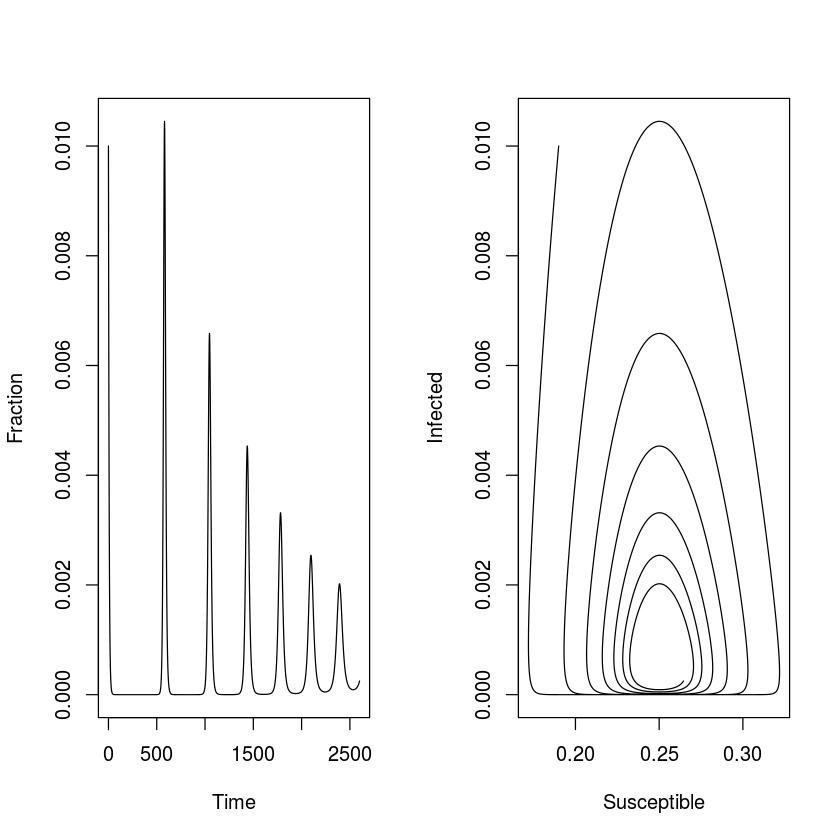

In [10]:
times  = seq(0, 52*50, by=.1)
parms  = c(mu = 1/(50*52), N = 1, beta =  2, 
     gamma = 1/2)
start = c(S=0.19, I=0.01, R = 0.8)
out = as.data.frame(ode(y=start, times=times, 
     func=sirmod, parms=parms))
par(mfrow=c(1,2)) #Make room for side-by-side plots 
plot(times, out$I, ylab="Fraction", xlab="Time", 
     type="l")
plot(out$S, out$I, type="l", xlab="Susceptible", 
     ylab="Infected")

Phase analysis
--------------

When working with dynamical systems we are often interested in studying the dynamics in the phase plane and derive the isoclines that divides this plane in regions of increase and decrease of the various state variables. The `phaseR` package is a wrapper around `ode` that makes it easy to analyse 1D and 2D ode’s [6]. The R-state in the SIR model does not influence the dynamics, so we can rewrite the SIR model as a 2D system.

In [11]:
simod = function(t, y, parameters) {
    S = y[1]
    I = y[2]
    
    beta = parameters["beta"]
    mu = parameters["mu"]
    gamma = parameters["gamma"]
    N = parameters["N"]
    
    dS = mu * (N - S) - beta * S * I/N
    dI = beta * S * I/N - (mu + gamma) * I
    res = c(dS, dI)
    list(res)
}

The isoclines (sometimes called the nullclines) in this system is given by the solution to the equations $dS/dt=0$ and $dI/dt=0$ and partitions the phase plane into regions were $S$ and $I$ are increasing and decreasing. For $N=1$, the $I$-isocline is $S = (\gamma +\mu)/\beta = 1/R_0$ and the S-isocline is $I= \mu (1/S-1)/\beta$. We can draw these in the phase plane and add a simulated trajectory to the plot (fig \[fig:siplane\]). The trajectory cycles in a counter-clockwise dampened fashion towards the endemic equilibrium (fig. \[fig:siplane\]). To visualize the expected change to the system at arbitrary points in the phase plane, we can further use the function `flowField` in the `phaseR`-package to superimpose predicted arrows of change (vectors) .

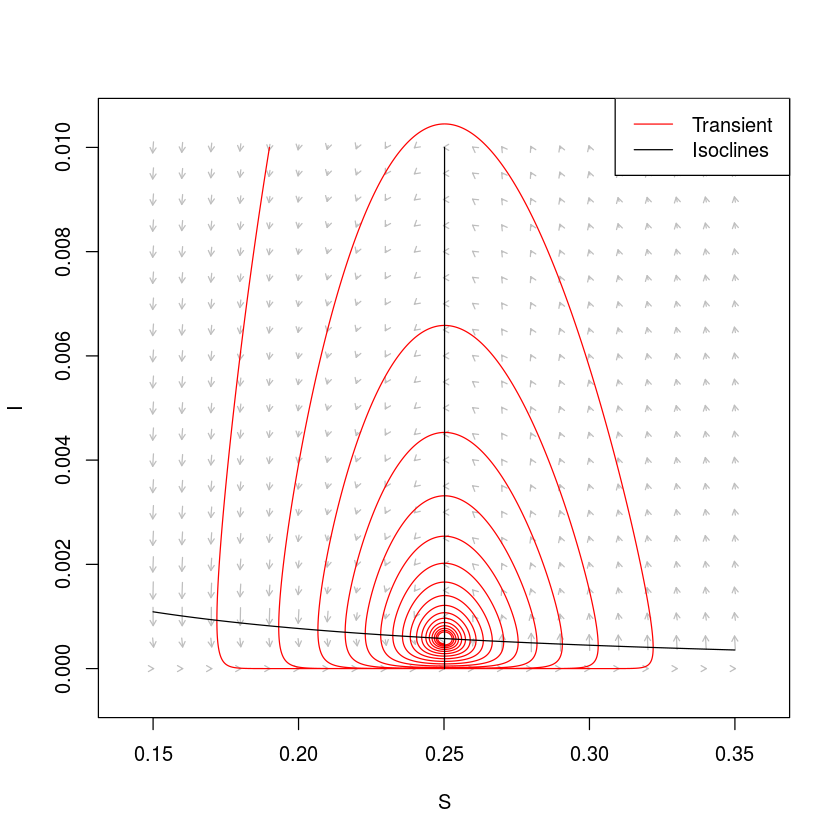

In [12]:
library(phaseR)
#Plot vector field
fld = flowField(simod, xlim = c(0.15,0.35), 
     ylim = c(0,.01), parameters = parms, system = "two.dim", 
     add = FALSE, ylab = "I", xlab = "S")
#Add trajectory
out = as.data.frame(ode(y = c(S = 0.19, I = 0.01), 
     times =  seq(0, 52*100, by = .1), func = simod, parms = parms))
 lines(out$S, out$I, col = "red")
#Add S-isocline
curve(parms["mu"]*(1/x-1)/parms["beta"], 0.15, 0.35, 
     xlab = "S", ylab = "I", add = TRUE)
#Add I-isocline
icline = (parms["gamma"] + parms["mu"])/parms["beta"]
lines(rep(icline, 2), c(0,0.01))
legend("topright", legend = c("Transient", "Isoclines"),
     lty = c(1, 1), col = c("red", "black"))

Stability and periodicity
-------------------------

If we work with continuos-time ODE models like the SIR, equilibria are locally stable if (and only if) all the real part of the eigenvalues of the the [](https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant) – when evaluated at the equilibrium – are smaller than zero. We will discuss stability and resonant periodicity in detail in chapter \[chap:c10\], so this section is just a teaser... An equilibrium is (i) a node (all trajectories moves monotonically towards/away from the equilibrium) if the largest eigenvalue has only real parts, or (ii) a focus (trajectories spiral towards or away from the equilibrium) if the largest eigenvalues are a conjugate pair of complex numbers ($a \pm b \imath$)[7]. For a focus the imaginary part determines the dampening period of the cycle according to $2 \pi / b$. We can thus use the Jacobian matrix to study the SIR model’s equilibria. If we let $F = dS/dt = \mu (N  - S)  - \beta S I / N$ and $G =  dI/dt = \beta S I / N - (\mu + \gamma) I$, the Jacobian of the SIR system is $$J=\left( \begin{array}{cc} \frac{\partial F}{\partial S} & \frac{\partial F}{\partial I} \\ \frac{\partial G}{\partial S} & \frac{\partial G}{\partial I}  \end{array} \right),$$ and the two equilibria are the disease-free equilibrium and the endemic equilibrium as defined above.

R can help with all of this. We first calculate the equilibria:

In [13]:
# Pull values from parms vector
gamma = parms["gamma"]
beta = parms["beta"]
mu = parms["mu"]
N = parms["N"]
# Endemic equilibrium
Sstar = (gamma + mu)/beta
Istar = mu * (beta/(gamma + mu) - 1)/beta
eq1 = list(S = Sstar, I = Istar)

We then calculate the elements of the Jacobian using R’s `D`-function:

In [14]:
# Define equations
dS = expression(mu * (N - S) - beta * S * I/N)
dI = expression(beta * S * I/N - (mu + gamma) * I)
# Differentiate w.r.t. S and I
j11 = D(dS, "S")
j12 = D(dS, "I")
j21 = D(dI, "S")
j22 = D(dI, "I")

We pass the values for $S^*$ and $I^*$ in the `eq1`-list to the Jacobian[8], and use `eigen`-function to calculate the eigenvalues:

In [15]:
#Evaluate Jacobian at equilibrium
J=with(data=eq1, expr=matrix(c(eval(j11),eval(j12),
     eval(j21),eval(j22)), nrow=2, byrow=TRUE))
#Calculate eigenvalues
eigen(J)$values

[1] -0.00076864+0.02400384i -0.00076864-0.02400384i

For the endemic equilibrium, the eigenvalues is a pair of complex conjugates which real parts are negative, so it is a stable focus. The period of the inwards spiral is:

In [16]:
2 * pi/(Im(eigen(J)$values[1]))

[1] 261.7575

So with these parameters the dampening period is predicted to be 261 weeks (just over 5 years). Thus, during disease invasion we expect this system to exhibit initial outbreaks every 5 years. A further significance of this number is that if the system is stochastically perturbed by, say, environmental variability affecting transmission, we expect the system to exhibit low amplitude ‘phase-forgetting’ cycles with approximately this period in the long run (see chapter \[chap:c10\]). We can make more accurate calculations of the stochastic system using *transfer functions* . We will visit on this more advanced topic in section \[sec:c10adv\].
The same protocol can be used on the the disease-free equilibrium $\{S^*=1, I^*=0\}$.

In [17]:
eq2=list(S=1,I=0)
J=with(eq2, 
     matrix(c(eval(j11),eval(j12),eval(j21),
     eval(j22)), nrow=2, byrow=TRUE))
eigen(J)$values

[1]  1.4996153846 -0.0003846154

The eigenvalues are strictly real and the largest value is greater than zero, so it is an unstable node (a ‘saddle’); The epidemic trajectory is predicted to move monotonically away from this disease free equilibrium if infection is introduced into the system. This makes sense because with the parameter values used, $R_0 = 3.99$ which is greater than the invasion-threshold value of 1.

Advanced: More realistic infectious periods
-------------------------------------------

The S(E)IR-type differential equation models assumes that rate of exit from the infectious classes are constant, the implicit assumption is thus that the infectious period is exponentially distributed among infected individuals; The average infectious period is $1/(\gamma+\mu)$, but an exponential fraction is infectious much shorter/longer than this. The chain-binomial model (see Section \[sec:c2cb\]), in contrast, assumes that everybody is infectious for a fixed period and then all instantaneously recover (or die). These assumptions are mathematically convenient, but in reality neither are particularly realistic. traced the chains of transmission of measles in multi-sibling household. The timing of secondary and tertiary cases were analyzed in detail by and . The average latent and infectious periods were calculated to be $8.58$ and $6.57$ days, respectively. While the distribution around each of these averages were not estimated separately (the latent period was assumed to be distributed and the infectious period assumed fixed), the variance around the roughly fortnight period of infection was estimated to be $3.13$. The mean duration of infection is thus $15.15$ days with a standard deviation of $1.77$ (fig \[fig:ch6gammainfper\]). So neither a fixed nor an exponential distribution is very accurate .

original model allows for arbitrary infectious-period distributions. We can write Kermack and McKendrick’s original equations as ‘renewal equations’ , introducing the additional notation of $k(t)$ being the (instantaneous) *incidence* at time $t$ (flux into the $I$-class at time t). $$\begin{aligned}
   \frac{dS}{dt} &=& \mu (N - S) - k(t) \label{eq:rens}\\
   k(t) &=& \beta I \frac{S}{N}\\
   \frac{dI}{dt} &=& k(t) - \mu I  - \int_0^\infty \frac{h(\tau)}{1-H(\tau)} k(t-\tau) d\tau \label{eq:reni}\\
   \frac{dR}{dt} &=& \int_0^\infty \frac{h(\tau)}{1-H(\tau)} k(t-\tau) d\tau - \mu R, \label{eq:renr}
  \end{aligned}$$ where $k(t-\tau)$ is the number of individuals that was infected $\tau$ time units ago, $h(\tau)$ is the probability of recovering on infection-day $\tau$ and $H(\tau)$ is the cumulative probability of having recovered by infection-day $\tau$; $k(t-\tau)/(1-H(\tau))$ is thus the fraction of individuals infected at time $t-\tau$ that still remains in the infected class on day $t$ and the integral is over all previous infections so as to quantify the total flux into the removed class at time $t$. Though intuitive, these general integro-differential equations (eqs \[eq:rens\]-\[eq:renr\]) are not easy to work with in general. For a restricted set of distributions for the $h()$-function, however – the [](https://en.wikipedia.org/wiki/Erlang_distribution) (the Gamma distribution with an integer shape parameter) – the model can be numerically integrated using a ‘Gamma-chain’ model of coupled ordinary differential equations . The trick is to separate any distributed-delay compartment into $u$ sub-compartments through which individuals pass through at a rate $\mbox{overallrate} * u$. The resultant infectious period will have a mean of $1/\mbox{overallrate}$ and a coefficient-of-variation of $1/\sqrt{u}$.

We can write a chain-SIR model to simulate $S \rightarrow I \rightarrow R$ flows with more realistic infectious period distributions[9]:

In [18]:
chainSIR = function(t, logx, params){
x = exp(logx)
u = params["u"]
S = x[1]
I = x[2:(u+1)]
R = x[u+2]
with(as.list(params),{
  dS = mu * (N - S)  - sum(beta * S * I) / N
  dI = rep(0, u)
  dI[1] = sum(beta * S * I) / N - (mu + u*gamma) * I[1]
  if(u>1){
     for(i in 2:u){
         dI[i] = u*gamma * I[i-1] - (mu+u*gamma)* I[i]
      }
   }
  dR = u*gamma * I[u] - mu * R
  res = c(dS/S, dI/I, dR/R)
  list(res)
})
}

We can compare the predicted dynamics of the simple SIR model with the $u=2$ chain model, the $u=500$ chain model (which is effectively the fixed-period delayed-differential model) and the ‘measles-realistic’ $u=73$ model.

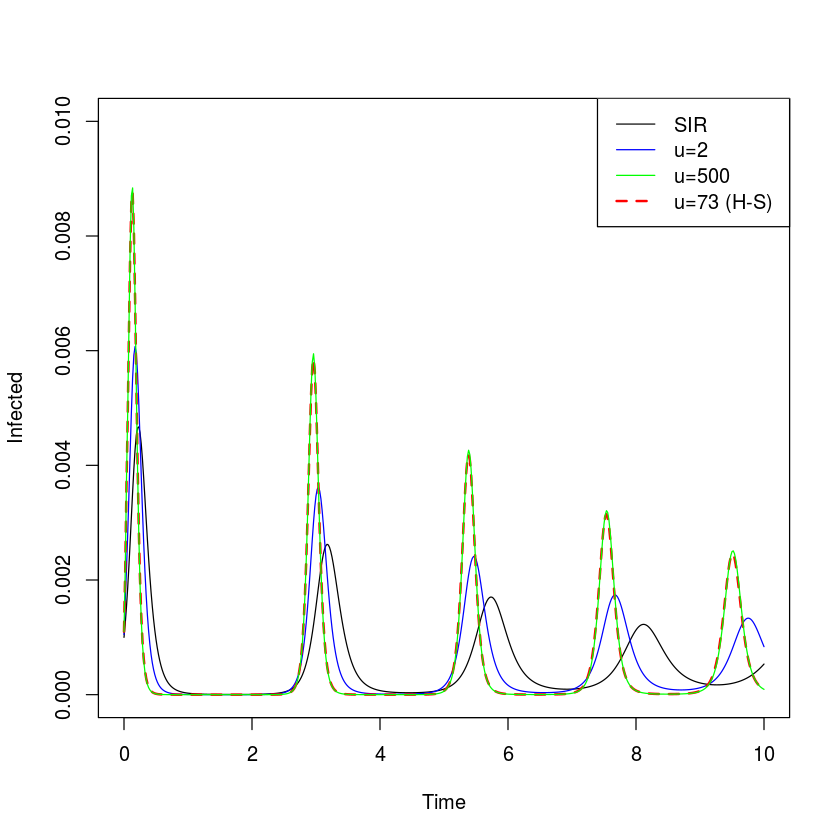

In [19]:
times = seq(0, 10, by=1/52)
paras2 = c(mu = 1/75, N = 1, beta =  625, 
     gamma = 365/14, u=1)
xstart2 = log(c(S = .06, I = c(0.001, rep(0.0001, 
     paras2["u"]-1)), R = 0.0001))
out = as.data.frame(ode(xstart2, times, chainSIR, 
     paras2))
plot(times, exp(out[,3]), ylab = "Infected", xlab =
     "Time", ylim = c(0, 0.01), type = 'l')

paras2["u"] = 2
xstart2 = log(c(S = .06, I = c(0.001, rep(0.0001/
     paras2["u"], paras2["u"]-1)), R = 0.0001))
out2 = as.data.frame(ode(xstart2, times, chainSIR, 
     paras2))
lines(times, apply(exp(out2[,-c(1:2,length(out2))]),
     1 ,sum), col = 'blue')

paras2["u"] = 73
xstart2 = log(c(S = .06, I = c(0.001, rep(0.0001/
     paras2["u"], paras2["u"]-1)), R = 0.0001))
out3 = as.data.frame(ode(xstart2, times, chainSIR, 
     paras2))
lines(times, apply(exp(out3[,-c(1:2,length(out3))]),
     1, sum), col='red', lwd=2, lty=2)

paras2["u"] = 500
xstart2 = log(c(S = .06, I = c(0.001, rep(0.0001/
     paras2["u"], paras2["u"]-1)), R = 0.0001))
out4 = as.data.frame(ode(xstart2, times, chainSIR, 
     paras2))
lines(times, apply(exp(out4[,-c(1:2,length(out4))]),
     1,sum, na.rm = TRUE), col = 'green')

legend("topright", legend = c("SIR", "u=2", "u=500", 
     "u=73 (H-S)"), lty = c(1,1,1,2), lwd = c(1,1,1, 2),
     col = c("black", "blue", "green", "red"))

The more narrow the infectious-period distribution, the more punctuated the predicted epidemics. However, infectious-period narrowing – alone – cannot sustain recurrent epidemics; In the absence of stochastic or seasonal forcing epidemics will dampen to the endemic equilibrium (though the damping period is slightly accelerated and the convergence on the equilibrium is slightly slower with narrowing infectious period distributions) (fig. \[fig:c2chain\]).

In the above we considered non-exponential infectious-period distributions. However, the general ODE chain method can be used for any compartment. , for example, used it to model non-exponential waining of natural and vaccine-induced immunity to whooping cough.